# Kpf-Bert를 이용한 뉴스기사 3줄요약 서비스  
전체기사에서 중요한 순서대로 상위 3개의 문장을 추출해서 제시하는 기사 요약 서비스이다.  
  
pytorch-lightning을 이용하여 전체프로세서를 작성하였다.  
  
BERT를 이용한 SUMMARY 관련 논문 및 nlpyang의 PreSumm 소스를 참조하였다.

In [ ]:
!pip install pytorch-lightning==1.2.8 --quiet --user
!pip install transformers==4.5.1 --quiet --user

In [1]:
import math
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

from torch.nn.init import xavier_uniform_

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import kss

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

In [2]:
MAX_TOKEN_COUNT = 512
N_EPOCHS = 10
BATCH_SIZE = 4

# data

한국어 문서 추출요약 AI 경진대회(~ 2020.12.09)에서 사용된 Bflysoft-뉴스기사 데이터셋에 맞춰 작성을 시작하였으나,
대회가 끝난 후 데이터가 비공개로 바뀌어 구할 수 없게 되었다.

대신 AI - HUB 에서 한국어 요약 데이터셋을 공개하여 이를 활용하였다.

In [4]:
DATA_TRAIN_PATH = 'data/train_original.json'
df = pd.read_json(DATA_TRAIN_PATH)
df = df.dropna()
len(df)#, len(val_df)

271093

In [5]:
DATA_TEST_PATH = 'data/vaild_original.json'
test_df = pd.read_json(DATA_TEST_PATH)
test_df = test_df.dropna()
len(test_df)

30122

In [6]:
train_df, val_df = train_test_split(df, test_size=0.05)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
train_df.shape, val_df.shape, test_df.shape

((257538, 3), (13555, 3), (30122, 3))

In [7]:
# test setting all data downsize
downsize = 2000
train_df = train_df[:downsize]
test_df = test_df[:downsize//10]
val_df = val_df[:downsize//10]

In [8]:
train_df.shape, test_df.shape, val_df.shape

((2000, 3), (200, 3), (200, 3))

# preprocess  
  
AI-HUB 문서요약 데이터셋 기준 전처리  
-> 기존 Bflysoft-뉴스기사 데이터셋에 맞춰 변환  
위 데이터를 구하지 못해서 다른 데이터를 변환한 것이다.  
사실 거칠 필요가 없는 과정이 되어버렸다.

In [9]:
def preprocess_data(data):
    outs = []
    for doc in data['documents']:
        line = []
        line.append(doc['media_name'])
        line.append(doc['id'])
        para = []
        for sent in doc['text']:
            for s in sent:
                para.append(s['sentence'])
        line.append(para)
        line.append(doc['abstractive'][0])
        line.append(doc['extractive'])
        a = doc['extractive']
        if a[0] == None or a[1] == None or a[2] == None:
            continue
        outs.append(line)

    outs_df = pd.DataFrame(outs)
    outs_df.columns = ['media', 'id', 'article_original', 'abstractive', 'extractive']
    return outs_df

In [10]:
train_df = preprocess_data(train_df)
train_df.head(1)

media         id                                   article_original  \
0  기호일보  359768259  [‘디플레 우려속’ 경기침체 시 자영업 대출 부실 뇌관 될 가능성, 자영업자와 가계...   

                                         abstractive extractive  
0  자영업자와 가계가 받은 대출이 1천900조원 턱밑까지 차오른 가운데, 업황 부진 속...  [1, 2, 3]

In [11]:
i = 8
print('===== 본    문 =====')
for idx, str in enumerate(train_df['article_original'][i]):
    print(idx,':',str)
print('===== 요약정답 =====')
print(train_df['extractive'][i])
print('===== 추출본문 =====')
print('1 :', train_df['article_original'][i][train_df['extractive'][i][0]])
print('2 :', train_df['article_original'][i][train_df['extractive'][i][1]])
print('3 :', train_df['article_original'][i][train_df['extractive'][i][2]])
print('===== 생성본문 =====')
print(train_df['abstractive'][i])

===== 본    문 =====
0 : [서울경제] '진심이 닿다' 이동욱-손성윤의 법정 대립이 예고돼 긴장감을 불러일으킨다.
1 : tvN 수목드라마 '진심이 닿다'(극본 이명숙, 최보림/ 연출 박준화/ 제작 스튜디오드래곤) 측이 20일, 5회 방송을 앞두고 법정에서 마주한 이동욱-손성윤의 스틸을 공개해 이목을 집중시킨다.
2 : 극중 이동욱은 올웨이즈 로펌 내 승소율과 클라이언트 신뢰도 모두 1위를 유지하고 있는 에이스 변호사 '권정록' 역을, 손성윤은 권정록의 첫 사랑이자 야망을 가진 서울 중앙 지검 검사 '유여름' 역을 맡았다.
3 : 무엇보다 권정록과 법대 동기인 유여름은 앞서 커피 취향까지 파악하고 있을 정도로 서로에 대해 잘 알고 투닥거리는 절친 면모로 오진심(예명 오윤서, 유인나 분)의 질투를 불러일으킨 바 있다.
4 : 이 가운데 공개된 스틸 속에는 한 법정에 선 변호사 권정록과 검사 유여름의 모습이 담겨있어 눈길을 끈다.
5 : 서로의 눈을 똑바로 쳐다보며 한치의 물러섬 없이 대립하고 있는 두 사람의 눈빛에서 팽팽한 긴장감이 느껴지는 듯 하다.
6 : 더욱이 검사석에 앉은 유여름을 등진 권정록의 결연한 표정으로부터 풍겨 나오는 서늘한 적막감이 보는 이들로 하여금 마른 침을 삼키게 한다.
7 : 동시에 무언가에 놀란 듯 동공지진을 일으키고 있는 오진심의 표정이 포착돼 무슨 상황인지 궁금증이 고조된다.
8 : 이는 앞서 유여름이 담당하게 된 임윤희 사건의 변호를 권정록이 맡게 되면서 변호사 대 검사로 맞서게 된 두 사람의 모습.
9 : 특히 폭행을 일삼던 남편을 죽인 피의자 임윤희의 정당방위와 살인죄를 두고 서로에게 반론을 제기하는 권정록-유여름의 피할 수 없는 법정 대립이 시선을 사로잡을 예정이다.
10 : 이에 한 순간에 대립각을 세우게 된 절친 권정록-유여름의 모습과 임윤희 사건의 진실에 궁금증이 모아진다.
11 : 그런가 하면 오진심은 권정록을 도와 임윤희 사건과 관련된 정보를 수집하고, 유여름을 예의주시하며 권정록을 알뜰살뜰 챙기는 비

In [12]:
test_df = preprocess_data(test_df)
test_df.head(1)

media         id                                   article_original  \
0  한국경제  340626877  [[ 박재원 기자 ] '대한민국 5G 홍보대사'를 자처한 문재인 대통령은 "넓고, ...   

                                         abstractive extractive  
0  8일 서울에서 열린 5G플러스 전략발표에 참석한 문재인 대통령은 5G는 대한민국 혁...  [0, 1, 3]

In [13]:
val_df = preprocess_data(val_df)
val_df.head(1)

media         id                                   article_original  \
0  충북일보  344733069  [［충북일보=서울］ 문재인 대통령은 12일 부처님 오신 날을 맞아 '화합'을 강조했...   

                                         abstractive extractive  
0  문재인 대통령은 부처님 오신 날을 맞아 12일 서울 종로 조계사에서 '화합'을 이야...  [0, 3, 5]

# tokenizer
kpfBERT 토크나이저를 바로 쓴다.
kpfBERT 토크나이저는 형태소와 유사하게 잘 토크나이징을 하게 설계되어 있다.

In [14]:
BERT_MODEL_NAME = 'kpfbert-base'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

# dataset
bert에서 여러문장을 입력하기 위해 presumm 에서 제안한 형식으로 인코딩 한다.  
  
token embedding : < CLS > 문장 < SEP > 문장 < SEP > 문장 ... 문장 < SEP >  
interval segment : 0 , 0 , 0 , 1 , 1 , 0 , 0 , ... 1 , 1  
position embedding : 1 , 1 , 1 , 1 , 1 , 1 , 1 , ... 1 , 1  
  
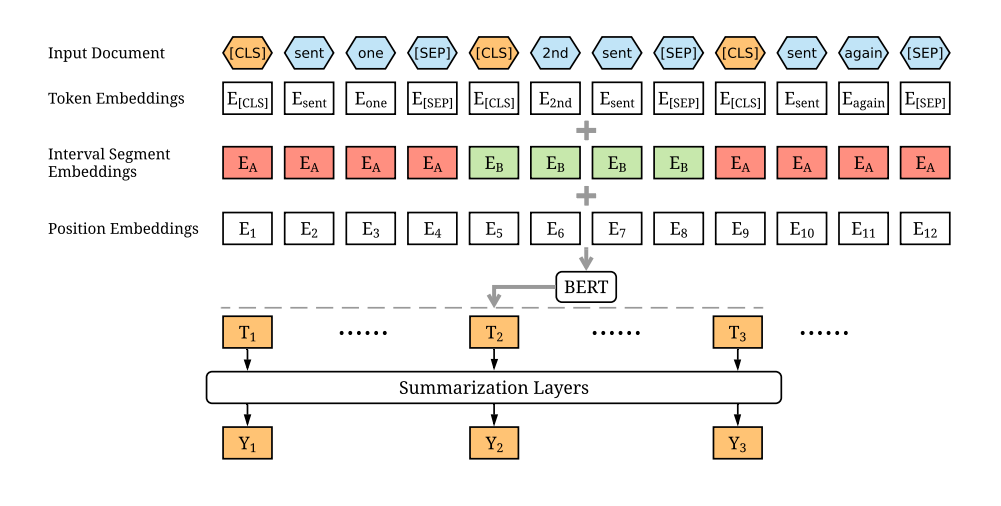

In [15]:
class SummDataset(Dataset):

    def __init__(
        self, 
        data: pd.DataFrame, 
        tokenizer: BertTokenizer, 
        max_token_len: int = 512
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        tokenlist = []
        for sent in data_row.article_original:
            tokenlist.append(tokenizer(
                text = sent,
                add_special_tokens = True)) #, # Add '[CLS]' and '[SEP]'
    
        src = [] # 토크나이징 된 전체 문단
        labels = []  # 요약문에 해당하면 1, 아니면 0으로 문장수 만큼 생성
        segs = []  #각 토큰에 대해 홀수번째 문장이면 0, 짝수번째 문장이면 1을 매핑
        clss = []  #[CLS]토큰의 포지션값을 지정

        odd = 0
        for tkns in tokenlist:
            if odd > 1 : odd = 0
            clss = clss + [len(src)]
            src = src + tkns['input_ids']
            segs = segs + [odd] * len(tkns['input_ids'])
            if tokenlist.index(tkns) in data_row.extractive :
                labels = labels + [1]
            else:
                labels = labels + [0]
            odd += 1
        
            #truncation
            if len(src) == MAX_TOKEN_COUNT:
                break
            elif len(src) > MAX_TOKEN_COUNT:
                src = src[:self.max_token_len - 1] + [src[-1]]
                segs = segs[:self.max_token_len]
                break
    
        #padding
        if len(src) < MAX_TOKEN_COUNT:
            src = src + [0]*(self.max_token_len - len(src))
            segs = segs + [0]*(self.max_token_len - len(segs))
            
        if len(clss) < MAX_TOKEN_COUNT:
            clss = clss + [-1]*(self.max_token_len - len(clss))
        if len(labels) < MAX_TOKEN_COUNT:
            labels = labels + [0]*(self.max_token_len - len(labels))

        return dict(
            src = torch.tensor(src),
            segs = torch.tensor(segs),
            clss = torch.tensor(clss),
            labels= torch.FloatTensor(labels)
        )

In [17]:
class SummDataModule(pl.LightningDataModule):

    def __init__(self, train_df, test_df, val_df, tokenizer, batch_size=1, max_token_len=512):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.test_df = test_df
        self.val_df = val_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = SummDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )

        self.test_dataset = SummDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )
    
        self.val_dataset = SummDataset(
            self.val_df,
            self.tokenizer,
            self.max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0 # windows는 0으로 고정해야 에러 안난다. num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=0 # windows는 0으로 고정해야 에러 안난다. num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=0 # windows는 0으로 고정해야 에러 안난다. num_workers=2
        )

In [18]:
data_module = SummDataModule(
  train_df,
  test_df,  
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

# MODEL
  
kpfBERT를 pretrained_bert로 불러와서 후처리 레이어를 추가하여 문장추출 모델을 만든다.

In [19]:
class PositionalEncoding(nn.Module):

    def __init__(self, dropout, dim, max_len=5000):
        pe = torch.zeros(max_len, dim)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp((torch.arange(0, dim, 2, dtype=torch.float) *
                              -(math.log(10000.0) / dim)))
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        pe = pe.unsqueeze(0)
        super(PositionalEncoding, self).__init__()
        self.register_buffer('pe', pe)
        self.dropout = nn.Dropout(p=dropout)
        self.dim = dim

    def forward(self, emb, step=None):
        emb = emb * math.sqrt(self.dim)
        if (step):
            emb = emb + self.pe[:, step][:, None, :]

        else:
            emb = emb + self.pe[:, :emb.size(1)]
        emb = self.dropout(emb)
        return emb

    def get_emb(self, emb):
        return self.pe[:, :emb.size(1)]

In [20]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, heads, d_ff, dropout):
        super(TransformerEncoderLayer, self).__init__()

        self.self_attn = MultiHeadedAttention(
            heads, d_model, dropout=dropout)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, iter, query, inputs, mask):
        if (iter != 0):
            input_norm = self.layer_norm(inputs)
        else:
            input_norm = inputs

        mask = mask.unsqueeze(1)
        context = self.self_attn(input_norm, input_norm, input_norm,
                                 mask=mask)
        out = self.dropout(context) + inputs
        return self.feed_forward(out)

In [21]:
class ExtTransformerEncoder(nn.Module):
    def __init__(self, hidden_size=768, d_ff=2048, heads=8, dropout=0.2, num_inter_layers=2):
        super(ExtTransformerEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_inter_layers = num_inter_layers
        self.pos_emb = PositionalEncoding(dropout, hidden_size)
        self.transformer_inter = nn.ModuleList(
            [TransformerEncoderLayer(hidden_size, heads, d_ff, dropout)
            for _ in range(num_inter_layers)])
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.wo = nn.Linear(hidden_size, 1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, top_vecs, mask):
        """ See :obj:`EncoderBase.forward()`"""

        batch_size, n_sents = top_vecs.size(0), top_vecs.size(1)
        pos_emb = self.pos_emb.pe[:, :n_sents]
        x = top_vecs * mask[:, :, None].float()
        x = x + pos_emb

        for i in range(self.num_inter_layers):
            x = self.transformer_inter[i](i, x, x, ~mask) 

        x = self.layer_norm(x)
        sent_scores = self.sigmoid(self.wo(x))
        sent_scores = sent_scores.squeeze(-1) * mask.float()

        return sent_scores

In [22]:
class PositionwiseFeedForward(nn.Module):
    """ A two-layer Feed-Forward-Network with residual layer norm.

    Args:
        d_model (int): the size of input for the first-layer of the FFN.
        d_ff (int): the hidden layer size of the second-layer
            of the FNN.
        dropout (float): dropout probability in :math:`[0, 1)`.
    """

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def gelu(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))


    def forward(self, x):
        inter = self.dropout_1(self.gelu(self.w_1(self.layer_norm(x))))
        output = self.dropout_2(self.w_2(inter))
        return output + x

In [23]:
class MultiHeadedAttention(nn.Module):
    """
    Multi-Head Attention module from
    "Attention is All You Need"
    :cite:`DBLP:journals/corr/VaswaniSPUJGKP17`.

    Similar to standard `dot` attention but uses
    multiple attention distributions simulataneously
    to select relevant items.

    .. mermaid::

       graph BT
          A[key]
          B[value]
          C[query]
          O[output]
          subgraph Attn
            D[Attn 1]
            E[Attn 2]
            F[Attn N]
          end
          A --> D
          C --> D
          A --> E
          C --> E
          A --> F
          C --> F
          D --> O
          E --> O
          F --> O
          B --> O

    Also includes several additional tricks.

    Args:
       head_count (int): number of parallel heads
       model_dim (int): the dimension of keys/values/queries,
           must be divisible by head_count
       dropout (float): dropout parameter
    """

    def __init__(self, head_count, model_dim, dropout=0.1, use_final_linear=True):
        assert model_dim % head_count == 0
        self.dim_per_head = model_dim // head_count
        self.model_dim = model_dim

        super(MultiHeadedAttention, self).__init__()
        self.head_count = head_count

        self.linear_keys = nn.Linear(model_dim,
                                     head_count * self.dim_per_head)
        self.linear_values = nn.Linear(model_dim,
                                       head_count * self.dim_per_head)
        self.linear_query = nn.Linear(model_dim,
                                      head_count * self.dim_per_head)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.use_final_linear = use_final_linear
        if (self.use_final_linear):
            self.final_linear = nn.Linear(model_dim, model_dim)

    def forward(self, key, value, query, mask=None,
                layer_cache=None, type=None, predefined_graph_1=None):
        """
        Compute the context vector and the attention vectors.

        Args:
           key (`FloatTensor`): set of `key_len`
                key vectors `[batch, key_len, dim]`
           value (`FloatTensor`): set of `key_len`
                value vectors `[batch, key_len, dim]`
           query (`FloatTensor`): set of `query_len`
                 query vectors  `[batch, query_len, dim]`
           mask: binary mask indicating which keys have
                 non-zero attention `[batch, query_len, key_len]`
        Returns:
           (`FloatTensor`, `FloatTensor`) :

           * output context vectors `[batch, query_len, dim]`
           * one of the attention vectors `[batch, query_len, key_len]`
        """

        batch_size = key.size(0)
        dim_per_head = self.dim_per_head
        head_count = self.head_count
        key_len = key.size(1)
        query_len = query.size(1)

        def shape(x):
            """  projection """
            return x.view(batch_size, -1, head_count, dim_per_head) \
                .transpose(1, 2)

        def unshape(x):
            """  compute context """
            return x.transpose(1, 2).contiguous() \
                .view(batch_size, -1, head_count * dim_per_head)

        # 1) Project key, value, and query.
        if layer_cache is not None:
            if type == "self":
                query, key, value = self.linear_query(query), \
                                    self.linear_keys(query), \
                                    self.linear_values(query)

                key = shape(key)
                value = shape(value)

                if layer_cache is not None:
                    device = key.device
                    if layer_cache["self_keys"] is not None:
                        key = torch.cat(
                            (layer_cache["self_keys"].to(device), key),
                            dim=2)
                    if layer_cache["self_values"] is not None:
                        value = torch.cat(
                            (layer_cache["self_values"].to(device), value),
                            dim=2)
                    layer_cache["self_keys"] = key
                    layer_cache["self_values"] = value
            elif type == "context":
                query = self.linear_query(query)
                if layer_cache is not None:
                    if layer_cache["memory_keys"] is None:
                        key, value = self.linear_keys(key), \
                                     self.linear_values(value)
                        key = shape(key)
                        value = shape(value)
                    else:
                        key, value = layer_cache["memory_keys"], \
                                     layer_cache["memory_values"]
                    layer_cache["memory_keys"] = key
                    layer_cache["memory_values"] = value
                else:
                    key, value = self.linear_keys(key), \
                                 self.linear_values(value)
                    key = shape(key)
                    value = shape(value)
        else:
            key = self.linear_keys(key)
            value = self.linear_values(value)
            query = self.linear_query(query)
            key = shape(key)
            value = shape(value)

        query = shape(query)

        key_len = key.size(2)
        query_len = query.size(2)

        # 2) Calculate and scale scores.
        query = query / math.sqrt(dim_per_head)
        scores = torch.matmul(query, key.transpose(2, 3))

        if mask is not None:
            mask = mask.unsqueeze(1).expand_as(scores)
            scores = scores.masked_fill(mask, -1e18) # how can i fix it to use fp16...

        # 3) Apply attention dropout and compute context vectors.

        attn = self.softmax(scores)

        if (not predefined_graph_1 is None):
            attn_masked = attn[:, -1] * predefined_graph_1
            attn_masked = attn_masked / (torch.sum(attn_masked, 2).unsqueeze(2) + 1e-9)

            attn = torch.cat([attn[:, :-1], attn_masked.unsqueeze(1)], 1)

        drop_attn = self.dropout(attn)
        if (self.use_final_linear):
            context = unshape(torch.matmul(drop_attn, value))
            output = self.final_linear(context)
            return output
        else:
            context = torch.matmul(drop_attn, value)
            return context


In [33]:
class Summarizer(pl.LightningModule):

    def __init__(self, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.max_pos = 512
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME) #, return_dict=True)
        self.ext_layer = ExtTransformerEncoder()
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.loss = nn.BCELoss(reduction='none')
    
        for p in self.ext_layer.parameters():
            if p.dim() > 1:
                xavier_uniform_(p)

    def forward(self, src, segs, clss, labels=None): #, input_ids, attention_mask, labels=None):
        
        mask_src = ~(src == 0) #1 - (src == 0)
        mask_cls = ~(clss == -1) #1 - (clss == -1)

        top_vec = self.bert(src, token_type_ids=segs, attention_mask=mask_src)
        top_vec = top_vec.last_hidden_state
        
        sents_vec = top_vec[torch.arange(top_vec.size(0)).unsqueeze(1), clss]
        sents_vec = sents_vec * mask_cls[:, :, None].float()

        sent_scores = self.ext_layer(sents_vec, mask_cls).squeeze(-1)
        
        loss = 0
        if labels is not None:
            loss = self.loss(sent_scores, labels)
            
            loss = (loss * mask_cls.float()).sum() / len(labels)
        
        return loss, sent_scores
    
    def step(self, batch):

        src = batch['src']
        if len(batch['labels']) > 0 :
            labels = batch['labels']
        else:
            labels = None
        segs = batch['segs']
        clss = batch['clss']
        
        loss, sent_scores = self(src, segs, clss, labels)    
        
        return loss, sent_scores, labels

    def training_step(self, batch, batch_idx):

        loss, sent_scores, labels = self.step(batch)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        
        return {"loss": loss, "predictions": sent_scores, "labels": labels}

    def validation_step(self, batch, batch_idx):
        
        loss, sent_scores, labels = self.step(batch)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        
        return {"loss": loss, "predictions": sent_scores, "labels": labels}

    def test_step(self, batch, batch_idx):
        
        loss, sent_scores, labels = self.step(batch)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        
        return {"loss": loss, "predictions": sent_scores, "labels": labels}

    def acc_loss(self, outputs):
        total_loss = 0
        hit_cnt = 0
        for outp in outputs:
            labels = outp['labels'].cpu()
            predictions, idxs = outp['predictions'].cpu().sort()
            loss = outp['loss'].cpu()
            for label, idx in zip(labels, idxs):
                for i in range(1,3):
                    if label[idx[-i-1]] == 1 : 
                        hit_cnt += 1

            total_loss += loss
            
        avg_loss = total_loss / len(outputs)
        acc = hit_cnt / (3*len(outputs)*len(labels))
        
        return acc, avg_loss
        
    def training_epoch_end(self, outputs):
        
        acc, avg_loss = self.acc_loss(outputs)
        
        print('acc:', acc, 'avg_loss:', avg_loss)
        
        self.log('avg_train_loss', avg_loss, prog_bar=True, logger=True)

    def validation_epoch_end(self, outputs):
        
        acc, avg_loss = self.acc_loss(outputs)
        
        print('val_acc:', acc, 'avg_val_loss:', avg_loss)
        
        self.log('avg_val_loss', avg_loss, prog_bar=True, logger=True)

    def test_epoch_end(self, outputs):
        
        acc, avg_loss = self.acc_loss(outputs)
        
        print('test_acc:', acc, 'avg_test_loss:', avg_loss)
        
        self.log('avg_test_loss', avg_loss, prog_bar=True, logger=True)

        return
        
    def configure_optimizers(self):
        
        optimizer = AdamW(self.parameters(), lr=2e-5)

        steps_per_epoch=len(train_df) // BATCH_SIZE
        total_training_steps = steps_per_epoch * N_EPOCHS
        
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=steps_per_epoch,
            num_training_steps=total_training_steps
        )

        return dict(
            optimizer=optimizer,
            lr_scheduler=dict(
                scheduler=scheduler,
                interval='step'
            )
        )

In [34]:
model = Summarizer()

Some weights of BertModel were not initialized from the model checkpoint at kpfbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# training

In [26]:
#windows
!rmdir /s /q lightning_logs
!rmdir /s /q  checkpoints

#linux
# !rm -rf lightning_logs/
# !rm -rf checkpoints/

In [27]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

In [28]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="avg_val_loss",
    mode="min"
)

In [29]:
logger = TensorBoardLogger("lightning_logs", name="kpfBERT_Summary")

In [30]:
early_stopping_callback = EarlyStopping(monitor='avg_val_loss', patience=3)

In [31]:
trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    callbacks=[early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=1,
#     precision=16, #소스 수정 또는 패키지 재설치 필요... 런타임 에러.
    progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [35]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                  | Params
----------------------------------------------------
0 | bert      | BertModel             | 114 M 
1 | ext_layer | ExtTransformerEncoder | 11.0 M
2 | loss      | BCELoss               | 0     
----------------------------------------------------
125 M     Trainable params
0         Non-trainable params
125 M     Total params
500.230   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

val_acc: 0.20833333333333334 avg_val_loss: tensor(16.2802)


Training: 0it [00:00, ?it/s]

acc: 0.2821666666666667 avg_loss: tensor(6.1244)


Validating: 0it [00:00, ?it/s]

Epoch 0, global step 499: avg_val_loss reached 5.01816 (best 5.01816), saving model to "D:\pythonworkspace\kpfbertsum\checkpoints\best-checkpoint.ckpt" as top 1


val_acc: 0.31666666666666665 avg_val_loss: tensor(5.0182)
acc: 0.3565 avg_loss: tensor(4.6197)


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 999: avg_val_loss reached 4.79628 (best 4.79628), saving model to "D:\pythonworkspace\kpfbertsum\checkpoints\best-checkpoint.ckpt" as top 1


val_acc: 0.30333333333333334 avg_val_loss: tensor(4.7963)
acc: 0.398 avg_loss: tensor(4.0393)


Validating: 0it [00:00, ?it/s]

Epoch 2, step 1499: avg_val_loss was not in top 1


val_acc: 0.3 avg_val_loss: tensor(4.9852)
acc: 0.4618333333333333 avg_loss: tensor(3.1439)


Validating: 0it [00:00, ?it/s]

Epoch 3, step 1999: avg_val_loss was not in top 1


val_acc: 0.2916666666666667 avg_val_loss: tensor(5.6665)
acc: 0.5408333333333334 avg_loss: tensor(1.8583)


Validating: 0it [00:00, ?it/s]

Epoch 4, step 2499: avg_val_loss was not in top 1


val_acc: 0.3016666666666667 avg_val_loss: tensor(8.0950)


1

In [36]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

test_acc: 0.37333333333333335 avg_test_loss: tensor(4.4954)
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 4.495447158813477}
--------------------------------------------------------------------------------


[{'test_loss': 4.495447158813477}]

# predictions

In [37]:
trained_model = Summarizer.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)
trained_model.eval()
trained_model.freeze()

Some weights of BertModel were not initialized from the model checkpoint at kpfbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [99]:
def data_process(text):
    # 문장 분리 하고,
    sents = kss.split_sentences(text)
    
    #데이터 가공하고,
    tokenlist = []
    for sent in sents:
        tokenlist.append(tokenizer(
            text = sent,
            add_special_tokens = True)) #, # Add '[CLS]' and '[SEP]'

    src = [] # 토크나이징 된 전체 문단
    labels = []  # 요약문에 해당하면 1, 아니면 0으로 문장수 만큼 생성
    segs = []  #각 토큰에 대해 홀수번째 문장이면 0, 짝수번째 문장이면 1을 매핑
    clss = []  #[CLS]토큰의 포지션값을 지정

    odd = 0

    for tkns in tokenlist:

        if odd > 1 : odd = 0
        clss = clss + [len(src)]
        src = src + tkns['input_ids']
        segs = segs + [odd] * len(tkns['input_ids'])
        odd += 1

        #truncation
        if len(src) == MAX_TOKEN_COUNT:
            break
        elif len(src) > MAX_TOKEN_COUNT:
            src = src[:MAX_TOKEN_COUNT - 1] + [src[-1]]
            segs = segs[:MAX_TOKEN_COUNT]
            break

    #padding
    if len(src) < MAX_TOKEN_COUNT:
        src = src + [0]*(MAX_TOKEN_COUNT - len(src))
        segs = segs + [0]*(MAX_TOKEN_COUNT - len(segs))

    if len(clss) < MAX_TOKEN_COUNT:
        clss = clss + [-1]*(MAX_TOKEN_COUNT - len(clss))

    return dict(
        sents = sents, #정답 출력을 위해...
        src = torch.tensor(src),
        segs = torch.tensor(segs),
        clss = torch.tensor(clss),
    )

In [118]:
def summarize_test(text):
    data = data_process(text.replace('\n',''))
    
    #trained_model에 넣어 결과값 반환
    _, rtn = trained_model(data['src'].unsqueeze(0), data['segs'].unsqueeze(0), data['clss'].unsqueeze(0))
    rtn = rtn.squeeze()
    
    # 예측 결과값을 받기 위한 프로세스
    rtn_sort, idx = rtn.sort(descending = True)
    
    rtn_sort = rtn_sort.tolist()
    idx = idx.tolist()

    end_idx = rtn_sort.index(0)

    rtn_sort = rtn_sort[:end_idx]
    idx = idx[:end_idx]
    
    if len(idx) > 3:
        rslt = idx[:3]
    else:
        rslt = idx
        
    summ = []
    print(' *** 입력한 문단의 요약문은 ...')
    for i, r in enumerate(rslt):
        summ.append(data['sents'][r])
        print('[', i+1, ']', summ[i])

    return summ

In [108]:
#테스트 문장 입력
test_context = '''이재명 더불어민주당 대선후보는 26일 변호사비 대납 의혹과 관련, "내가 정말로 변호사비를 불법으로 받았으면 나를 구속하라"고 반박했다.
이 후보는 이날 오후 전남 신안군 응급의료 전용헬기 계류장에서 열린 '국민반상회' 후 기자들과 만나 한 시민단체 대표가 고액 수임료 의혹 증거라며 제시한 녹취록에 대해 "조작됐다는 증거를 갖고 있고 검찰에도 제출했다. 검찰과 수사기관들은 빨리 처리하시라"며 이같이 말했다.
앞서 이민구 깨어있는시민연대당 대표는 이 후보가 특정 변호사에게 수임료로 현금과 주식 등 20억원을 줬다는 의혹을 주장하며 녹취록을 제출한 바 있다. 이에 대해 송평수 선대위 부대변인은 "허위사실"이라며 "깨시민당 이 대표에게 제보를 했다는 시민단체 대표 이모 씨가 제3자로부터 기부금을 받아낼 목적으로 허위사실을 녹음한 후, 이 모 변호사에게까지 접근했다. 이러한 비상식적이고 악의적인 행태는 이재명 후보에 대한 정치적 타격을 가할 목적으로 치밀하게 준비한 것"이라고 반박했다.
이에 대해 이 후보는 "그것도 조직폭력배 조작에 버금가는 조작사건이라는 게 곧 드러날 것"이라며 "팩트확인을 하고 언급하면 좋겠다. 당사자도 아니고 제3자들이 자기끼리 녹음한 게 가치가 있느냐"고 반문했다.
그는 "사실이 아니면 무고하고 음해하는 사람들을 무고 혐의나 공직선거법 위반으로 빨리 처리해서 처벌하시라"며 "선거 국면에서 하루이틀도, 한두번도 아니고 '조폭이 뇌물 줬다'는 (허위사실 유포를) 왜 아직도 처리 안 하고 있느냐"고 검경에 불만을 드러냈다.
이어 "허위사실이 드러났으면 당연히 다시는 그런 일이 없게 해야 하는 것 아닌가. 이해가 안 된다"며 "선거관리, 또는 범죄를 단속하는 국가기관들이 이런 식으로 허위사실 유포나 무고 행위를 방치해 정치적 공격 수단으로 쓰게 하면 안 된다"고 했다.
이 후보는 또 자신이 구민주-동교동계와 접촉해 복당을 타진했다는 언론보도와 관련해선 "구체적으로 어떤 사람을 범주별로 나눠 무슨 계, 진영으로 말하는 것은 아니다"라며 "시점을 언젠가 정해 벌점이니, 제재니, 제한이니 다 없애고 모두가 합류할 수 있도록 할 생각"이라고 말했다.
종전에 언급했던 '대사면' 방침을 재확인한 셈이다. 그는 "민주당에 계셨던 분, 또 민주당에 있지 않았더라도 앞으로 함께할 분들에게 계속 연락을 하고 있다"며 "만나고 전화하고 힘을 합치자고 권유하고 있다"고 했다.
그는 " 현재 민주당이 이미 열린민주당과의 통합을 협의하고 있다"며 "거기에 더해서 꼭 민주계라고 말할 필요는 없고 부패사범이나 파렴치범으로 탈당하거나 또는 제명된 사람들이 아니라면, 국가의 미래를 걱정하는 민주개혁 진영의 일원이라면 가리지 말고 과거의 어떤 일이든 그러지 말고 힘을 합치자"고 강조했다.
언론보도에 따르면, 이 후보는 최근 구민주계인 정대철 전 고문과 연락을 주고 받으며 천정배, 정동영 전 의원 등 민주당을 탈당했던 옛 동교동계와 호남 인사들의 복당을 타진했다.
'''

In [113]:
rtn = summarize_test(test_context)

 *** 입력한 문단의 요약문은 ...
[ 1 ] 이재명 더불어민주당 대선후보는 26일 변호사비 대납 의혹과 관련, "내가 정말로 변호사비를 불법으로 받았으면 나를 구속하라"고 반박했다.
[ 2 ] 이 후보는 이날 오후 전남 신안군 응급의료 전용헬기 계류장에서 열린 '국민반상회' 후 기자들과 만나 한 시민단체 대표가 고액 수임료 의혹 증거라며 제시한 녹취록에 대해 "조작됐다는 증거를 갖고 있고 검찰에도 제출했다.
[ 3 ] 검찰과 수사기관들은 빨리 처리하시라"며 이같이 말했다.


In [114]:
#테스트 문장 입력
test_context = '''두산 베어스의 56억 외야수 정수빈(31)이 모교 유신고 후배들을 위해 통 큰 기부를 했다.

정수빈은 지난 22일 모교인 수원 유신고등학교에 학교발전기금 1천만원을 기탁한 것으로 알려졌다. 정수빈의 은사인 유신고 이성열 감독은 26일 OSEN과의 전화통화에서 “(정)수빈이가 최근 학교에 와서 후배들이 필요한 곳에 사용하라며 발전기금을 기부했다”고 전했다.

정수빈은 유신고를 졸업하고 2009년 두산 2차 5라운드 39순위로 입단해 13년 동안 베어스 외야 한 자리를 지키고 있다. 2021시즌에 앞서 두산과 6년 최대 56억원에 FA 계약을 맺었고, 가을 사나이라는 별명에 걸맞게 이번 포스트시즌서 타율 3할1푼1리(45타수 14안타)로 활약하며 팀의 KBO리그 최초 7년 연속 한국시리즈행을 이끌었다.

정수빈의 선행은 이번이 처음이 아니다. 2009년 데뷔 때부터 불우이웃, 난치병 환우, 어린이 팬들을 위해 꾸준히 선물과 추억을 선사했고, 올해 FA 대박을 맞아 모교의 후배들까지 챙기는 선한 영향력을 발휘했다.

이성열 감독은 “사실 그 전에 유한준(은퇴), 최정(SSG) 등 다른 프로에 간 제자들도 학교에 많은 도움을 줬다. 이어 정수빈, 소형준(KT)과 같은 후배들이 자연스럽게 선배들을 따라하는 문화가 만들어졌다”며 “학교에 보이지 않는 도움이 참 많다. 덕분에 팀 운영에 큰 힘이 된다. 감독으로서 항상 고마울 따름이다”라고 성공한 제자의 선행에 감사를 표했다.
'''

In [119]:
rtn = summarize_test(test_context)

 *** 입력한 문단의 요약문은 ...
[ 1 ] 정수빈은 지난 22일 모교인 수원 유신고등학교에 학교발전기금 1천만원을 기탁한 것으로 알려졌다.
[ 2 ] 두산 베어스의 56억 외야수 정수빈(31)이 모교 유신고 후배들을 위해 통 큰 기부를 했다.
[ 3 ] 정수빈의 은사인 유신고 이성열 감독은 26일 OSEN과의 전화통화에서 “(정)수빈이가 최근 학교에 와서 후배들이 필요한 곳에 사용하라며 발전기금을 기부했다”고 전했다.


In [120]:
#테스트 문장 입력
test_context = '''장우혁이 주식 손해사를 전했다.

11월 26일 방송된 SBS 파워FM '두시탈출 컬투쇼'(이하 '컬투쇼') '손해사정사' 코너에는 개그맨 박성광이 스페셜 DJ로 함께한 가운데 가수 빽가, 장우혁이 게스트로 출연했다.

이날 장우혁은 과거에 굉장한 부자였다는 소리가 있다는 말에 "아버지가 사업을 작지 않게 하셨다"고 밝혔다. 하지만 어린 시절 가세가 기울었다고. 장우혁은 "제가 누리단 이런 데에서 캠핑을 갔다가 집이 망하는 꿈을 꿨다. 그리고 집에 도착했는데 진짜 그런 상황이 일어났더라"며 예지몽과 함께 짐을 쌌던 일화를 전했다.

장우혁은 자신이 직접 본 손해로는 주식을 언급했다. 장우혁은 "저는 주식을 절대 하지 않는다. 제가 모르는 미지의 세계를 더 이상 절대 하지 않는다"며 과거 엄청난 액수의 손해를 본 사실을 밝혔다.

장우혁은 "얼마 전에 (주식창에 들어)갔다. 90얼마가 있더라. 원래는 그거의 100배를 넣었다"고 말했다. 장우혁은 9천만 원을 투자한 거냐는 물음에 "그 이상으로 있었다"며 기존의 어마어마한 투자 액수를 드러냈다.

장우혁은 "너무 화가 나서 네가 이기나, 내가 이기나 하는 마음으로 놔뒀다. 여러 개가 폐지되고 하나 살아남았는데 빼려고 하니 뺄 수 없는 종목이라고 하더라. 그래서 0원이나 마찬가지"라고 덧붙였다. 장우혁은 재차 "그래서 이제 안 한다"고 강조했고, 이런 장우혁을 지켜본 빽가, 박성광은 "후회하지 않는다고 하는데 눈가가 지금 촉촉하다"며 안타까움을 드러냈다.
'''

In [121]:
rtn = summarize_test(test_context)

 *** 입력한 문단의 요약문은 ...
[ 1 ] 11월 26일 방송된 SBS 파워FM '두시탈출 컬투쇼'(이하 '컬투쇼') '손해사정사' 코너에는 개그맨 박성광이 스페셜 DJ로 함께한 가운데 가수 빽가, 장우혁이 게스트로 출연했다.
[ 2 ] 이날 장우혁은 과거에 굉장한 부자였다는 소리가 있다는 말에 "아버지가 사업을 작지 않게 하셨다"고 밝혔다. 하지만 어린 시절 가세가 기울었다고. 장우혁은 "제가 누리단 이런 데에서 캠핑을 갔다가 집이 망하는 꿈을 꿨다.
[ 3 ] 장우혁은 자신이 직접 본 손해로는 주식을 언급했다.
